# Selections

Selections on parameters including flux, distance and any auxiliary variables, can be performed in arbitrarily complex way.
We are familiar now with how to add selections onto fluxes and distances, now we will examine in more detail.



## built in selection functions

There are several available selection functions:

In [1]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

from jupyterthemes import jtplot

jtplot.style(context="notebook", fscale=1, grid=False)
purple = "#B833FF"
yellow = "#F6EF5B"

import popsynth

popsynth.loud_mode()
popsynth.list_available_selection_functions()

DummySelection
UnitySelection
BernoulliSelection
BoxSelection
LowerBound
UpperBound
SoftSelection
HardFluxSelection
SoftFluxSelection
GalacticPlaneSelection
DistanceSelection


We can use these to set selections on parameters. Let's add a dummy parameter that is sampled from a normal distribution:

In [2]:
aux_parameter = popsynth.NormalAuxSampler(name="dummy", observed=False)
aux_parameter.mu = 0
aux_parameter.sigma = 1

Now we will use the built in Box selection function. Here, we will assign it to an auxiliary sampler, so we need to tell it to select on the observed value:

In [3]:
box_select = popsynth.BoxSelection(name="aux_selector", use_obs_value=True)
box_select.vmin = 0
box_select.vmax = 0.5

We can also add on a selection function for the flux

In [4]:
flux_select = popsynth.HardFluxSelection()
flux_select.boundary = 1e-6

Now, we can put it all together and create a survey:

In [5]:
ps = popsynth.SchechterZPowerCosmoPopulation(
    Lambda=50, delta=-2, Lmin=1e52, alpha=1.5, seed=1234
)

aux_parameter.set_selection_probability(box_select)

ps.set_flux_selection(flux_select)

ps.add_auxiliary_sampler(aux_parameter)

pop = ps.draw_survey()

 INFO     |  registering auxilary sampler: dummy 


 INFO     |  The volume integral is 371.0099992828878 


Drawing distances:   0%|          | 0/352 [00:00<?, ?it/s]

 INFO     |  Expecting 352 total objects 


 INFO     |  Sampling: dummy 


 INFO     |  applying selection to fluxes 


 INFO     |  Applying selection from dummy which selected 67 of 352 objects 


 INFO     |  Before auxiliary selection there were 226 objects selected 


 INFO     |  Detected 42 distances 


 INFO     |  Detected 42 objects out to a distance of 1.84 


 WARNING  |  This will be removed in future versions use x.fluxes 


 WARNING  |  This will be removed in future versions use x.fluxes.selected 


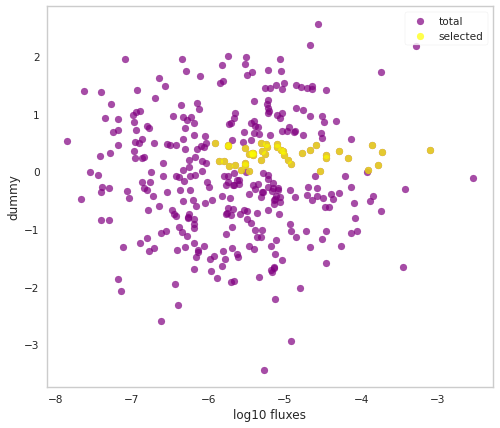

In [6]:
fig, ax = plt.subplots()

ax.scatter(
    np.log10(pop.fluxes_observed), pop.dummy, color="purple", alpha=0.7, label="total"
)
ax.scatter(
    np.log10(pop.selected_fluxes_observed),
    pop.dummy.selected,
    color="yellow",
    alpha=0.7,
    label="selected",
)

ax.set(xlabel="log10 fluxes", ylabel="dummy")
ax.legend()

## custom selections

we can also create our own custom selection functions.


First, we will look at simply creating a selection. For simplicity, we will look at the Bernoulli selection class built in:

In [7]:
class BernoulliSelection(popsynth.SelectionProbability):
    
    # required to register class!
    _selection_name = "BernoulliSelection"

    # define the parameters to be used
    probability = popsynth.SelectionParameter(vmin=0, vmax=1, default=0.5)

    def __init__(self) -> None:

        super(BernoulliSelection, self).__init__(name="Bernoulli")

    def draw(self, size: int) -> None:
        """
        The draw function takes an integer for the size of the 
        samples and sets the private variable _selections which 
        should be an array of boolean values
        
        """
        
        self._selection = stats.bernoulli.rvs(
                self._probability, size=size).astype(bool)  # type: np.ndarray


The procedure can become arbitraliy complex. It is important to note that selections will know about several private variables:

```_observed_flux```
```_observed_value```
```_distance```
```_luminosity```


which enables you to use these values in your selection function.

Because of this, several of the build in selections can be used to select on these variables (though some of this is done in the background for you.)


```python
my_box_selection = popsynth.BoxSelection(name="box_flux_selection", use_flux=True)
my_box_selection.vmin = 1E-4
my_box_selection.vmax = 1E-2

```

Setting this as the flux selector will select only the fluxes above and below the limits